In [1]:
%load_ext autoreload
%autoreload 2import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def resize(data, size):
    scaled = np.zeros((data.shape[0],) + size + (3,))
    for i, img in enumerate(data):
        scaled[i,...] = cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)
    return scaled

In [3]:
input_shape = (96,96,3)

(x_train, y_train), (x_val, y_val) = cifar10.load_data()
x_train = (resize(x_train, size=input_shape[:2])-127)/128
x_val = (resize(x_val, size=input_shape[:2])-127)/128
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
print(x_train.shape)

(50000, 96, 96, 3)


In [4]:
model = tf.keras.applications.InceptionResNetV2(include_top=True, classes=10, 
    weights=None, input_shape=input_shape)

weight_decay = 1e-3

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        layer.add_loss(tf.keras.regularizers.l2(weight_decay)(layer.kernel))

optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])

W1230 16:48:14.996059 140024589399872 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [6]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), 
                    epochs=25, validation_data=(x_val,y_val))

# Save model and weights
model_name = 'inception_resnet_v2_cifar10_v4.h5'
model.save(model_name)
print('Saved trained model at %s' % model_name)

Epoch 1/25
782/782 [==============================] - 231s 295ms/step - loss: 43.6771 - acc: 0.4718 - val_loss: 29.8202 - val_acc: 0.5709
Epoch 2/25
782/782 [==============================] - 186s 238ms/step - loss: 21.5787 - acc: 0.6058 - val_loss: 15.3585 - val_acc: 0.6424
Epoch 3/25
782/782 [==============================] - 186s 238ms/step - loss: 11.9094 - acc: 0.6684 - val_loss: 9.3739 - val_acc: 0.6785
Epoch 4/25
782/782 [==============================] - 188s 241ms/step - loss: 7.7556 - acc: 0.7136 - val_loss: 6.5590 - val_acc: 0.7135
Epoch 5/25
782/782 [==============================] - 185s 237ms/step - loss: 5.6414 - acc: 0.7474 - val_loss: 4.9050 - val_acc: 0.7651
Epoch 6/25
782/782 [==============================] - 185s 237ms/step - loss: 4.3537 - acc: 0.7763 - val_loss: 4.0723 - val_acc: 0.7353
Epoch 7/25
782/782 [==============================] - 184s 235ms/step - loss: 3.4976 - acc: 0.7944 - val_loss: 3.3103 - val_acc: 0.7547
Epoch 8/25
782/782 [=======================

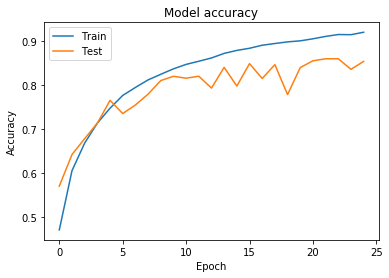

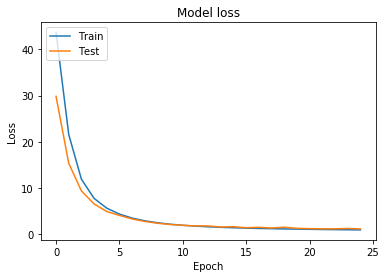

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
model.evaluate(x_val, y_val)

10000/10000 [==============================] - 15s 1ms/sample - loss: 1.1560 - acc: 0.8535


[1.156026328086853, 0.8535]